# 前言

**在做因子开发时突然在想有些因子不一定非得用于选股,根据因子金融逻辑(或者IC等)用于开发择时信号也许也会有不错的效果,于是便有了此篇尝试。**

**低波效应**是由投资者的交易行为引发的市场现象，表现为过去波动较大的股票会在未来有较大回调的风险，从而相比全市场有较为显著的负超额收益。低波效应的核心逻辑在于**由投资者的过度反应带来的股价变动相对于市场异常现象的均值回归**，当投资者对于个股在短期内存在非理性“追捧”时，个股波动迅速上升，相比于市场的价格变动也呈现同步性的异常，但这种非理性不可长期持续，最终个股价格会随着交易行为回归正常而回落至合理价格区间，波动率因子的构建即基于低波效应带来的确定性收益。


**波动率因子：**过去 21 天收益率标准差作为基础波动率因子。

**特异波动率因子：**以 fama 三因子模型为基础，对过去 21 天个股收益率做市场收 益率、规模因子收益率和价值因子收益率的线性回归，取残差计算标准差作为特异波动率因子。


**特异度因子：**作为简单衡量个股交易行为异常的描述，其构建方式为对过去21天个股收益率做市场收益率、规模收益率和价值收益率的线性回归，取回归的拟合优度，以 1-拟合优度作为特异率因子，特异率因子值越大，个股存在更多的交易异常行为。

**特异度因子**的逻辑是:个股表现反常的原因多种多样，如市场多空双方博弈力量的局部改变、公司出现突发事件，但从结果上看，价格可以反应消化所有信息，故从资产定价模型出发，个股的收益可以被市场中共同因素解释，所以个股表现是否“反常”，可以以个股和市场表现的一致性进行刻画。而FF3模型恰好描述了个股的收益率可以由市场收益、大小市值相对收益和高低估值相对收益解释，故使用FF3定义特异率因子在好不过了。

**FF3模型**

$$r_t = \alpha_t + \beta_{MKT}MKT_t+\beta_{SMB}SMB_t+\beta_{HMB}HMB_t+\varepsilon_t$$

我们以模型的$R^{2}$为特异度因子,$R^{2}$为:

$$R^{2}=1 - \frac{SSR}{SST}$$

其中:

$$SSR = \sum(r_i - \hat{r_{i}})$$

$$SST = \sum(r_i-\bar{r_i})$$

现在我们在看看波动率和特意波动率公式:

$$特别波动率=\sqrt{\frac{\sum(r_i-\hat{r_i})^2}{N-1}}$$
$$波动率=\sqrt{\frac{\sum(r_i-\bar{r_i})^2}{N-1}}$$

故特异度因子于特意波动和波动率的关系如下:

$$特异度=\frac{特别波动率^2}{波动率^2} \Rightarrow 特异波动率=\sqrt{特异度}*波动率$$



In [1]:
# 初始引入
import sys
sys.path.append('../..')

from BuildPeriodicDate import *

import talib
import numpy as np
import pandas as pd
import empyrical as ep
import scipy.stats as st
import statsmodels.api as sm 

import alphalens as al
from alphalens import plotting
import alphalens.performance as perf

from jqdata import *
from jqfactor import (Factor, calc_factors)

from functools import reduce
from tqdm import tqdm_notebook
from typing import (Tuple, List)
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt


mpl.rcParams['font.family'] = 'serif'  # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

In [2]:
'''
最大回撤相关
    绘制回撤区间图
    回撤区间列表
    from https://github.com/quantopian/pyfolio
'''

# step 1


def get_max_drawdown_underwater(underwater):
    """
    Determines peak, valley, and recovery dates given an 'underwater'
    DataFrame.
    An underwater DataFrame is a DataFrame that has precomputed
    rolling drawdown.
    Parameters
    ----------
    underwater : pd.Series
       Underwater returns (rolling drawdown) of a strategy.
    Returns
    -------
    peak : datetime
        The maximum drawdown's peak.
    valley : datetime
        The maximum drawdown's valley.
    recovery : datetime
        The maximum drawdown's recovery.
    """

    valley = underwater.idxmin()  # end of the period
    # Find first 0
    peak = underwater[:valley][underwater[:valley] == 0].index[-1]
    # Find last 0
    try:
        recovery = underwater[valley:][underwater[valley:] == 0].index[0]
    except IndexError:
        recovery = np.nan  # drawdown not recovered
    return peak, valley, recovery

# step 2


def get_top_drawdowns(returns, top=10):
    """
    Finds top drawdowns, sorted by drawdown amount.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        The amount of top drawdowns to find (default 10).
    Returns
    -------
    drawdowns : list
        List of drawdown peaks, valleys, and recoveries. See get_max_drawdown.
    """

    returns = returns.copy()
    df_cum = np.exp(np.log1p(returns).cumsum())
    running_max = np.maximum.accumulate(df_cum)
    underwater = df_cum / running_max - 1

    drawdowns = []
    for _ in range(top):
        peak, valley, recovery = get_max_drawdown_underwater(underwater)
        # Slice out draw-down period
        if not pd.isnull(recovery):
            underwater.drop(underwater[peak: recovery].index[1:-1],
                            inplace=True)
        else:
            # drawdown has not ended yet
            underwater = underwater.loc[:peak]

        drawdowns.append((peak, valley, recovery))
        if ((len(returns) == 0)
                or (len(underwater) == 0)
                or (np.min(underwater) == 0)):
            break

    return drawdowns

# 通过上面两个步骤 就可以取得对应的最大回撤表格


def gen_drawdown_table(returns, top=10):
    """
    Places top drawdowns in a table.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        The amount of top drawdowns to find (default 10).
    Returns
    -------
    df_drawdowns : pd.DataFrame
        Information about top drawdowns.
    """

    df_cum = np.exp(np.log1p(returns).cumsum())
    drawdown_periods = get_top_drawdowns(returns, top=top)
    df_drawdowns = pd.DataFrame(index=list(range(top)),
                                columns=['Net drawdown in %',
                                         'Peak date',
                                         'Valley date',
                                         'Recovery date',
                                         'Duration'])

    for i, (peak, valley, recovery) in enumerate(drawdown_periods):
        if pd.isnull(recovery):
            df_drawdowns.loc[i, 'Duration'] = np.nan
        else:
            df_drawdowns.loc[i, 'Duration'] = len(pd.date_range(peak,
                                                                recovery,
                                                                freq='B'))
        df_drawdowns.loc[i, 'Peak date'] = (peak.to_pydatetime()
                                            .strftime('%Y-%m-%d'))
        df_drawdowns.loc[i, 'Valley date'] = (valley.to_pydatetime()
                                              .strftime('%Y-%m-%d'))
        if isinstance(recovery, float):
            df_drawdowns.loc[i, 'Recovery date'] = recovery
        else:
            df_drawdowns.loc[i, 'Recovery date'] = (recovery.to_pydatetime()
                                                    .strftime('%Y-%m-%d'))
        df_drawdowns.loc[i, 'Net drawdown in %'] = (
            (df_cum.loc[peak] - df_cum.loc[valley]) / df_cum.loc[peak]) * 100

    df_drawdowns['Peak date'] = pd.to_datetime(df_drawdowns['Peak date'])
    df_drawdowns['Valley date'] = pd.to_datetime(df_drawdowns['Valley date'])
    df_drawdowns['Recovery date'] = pd.to_datetime(
        df_drawdowns['Recovery date'])

    return df_drawdowns

# 将上面的df转为图


def show_worst_drawdown_periods(returns, top=5):
    """
    Prints information about the worst drawdown periods.
    Prints peak dates, valley dates, recovery dates, and net
    drawdowns.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        Amount of top drawdowns periods to plot (default 5).
    """

    drawdown_df = gen_drawdown_table(returns, top=top)
    print_table(
        drawdown_df.sort_values('Net drawdown in %', ascending=False),
        name='Worst drawdown periods',
        float_format='{0:.2f}'.format,
    )

# 根据步骤1，2画图


def plot_drawdown_periods(returns, top=10, ax=None, **kwargs):
    """
    Plots cumulative returns highlighting top drawdown periods.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    top : int, optional
        Amount of top drawdowns periods to plot (default 10).
    ax : matplotlib.Axes, optional
        Axes upon which to plot.
    **kwargs, optional
        Passed to plotting function.
    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """
    from matplotlib.ticker import FuncFormatter
    if ax is None:
        ax = plt.gca()

    def two_dec_places(x, y): return '%.2f' % x
    y_axis_formatter = FuncFormatter(two_dec_places)
    ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

    df_cum_rets = np.exp(np.log1p(returns).cumsum())
    df_drawdowns = gen_drawdown_table(returns, top=top)

    df_cum_rets.plot(ax=ax, **kwargs)

    lim = ax.get_ylim()
    colors = sns.cubehelix_palette(len(df_drawdowns))[::-1]
    for i, (peak, recovery) in df_drawdowns[
            ['Peak date', 'Recovery date']].iterrows():
        if pd.isnull(recovery):
            recovery = returns.index[-1]
        ax.fill_between((peak, recovery),
                        lim[0],
                        lim[1],
                        alpha=.4,
                        color=colors[i])
    ax.set_ylim(lim)
    ax.set_title('Top %i drawdown periods' % top)
    ax.set_ylabel('Cumulative returns')
    ax.legend(['Portfolio'], loc='upper left',
              frameon=True, framealpha=0.5)
    ax.set_xlabel('')
    return ax

def print_table(table,
                name=None,
                float_format=None,
                formatters=None,
                header_rows=None):
    """
    Pretty print a pandas DataFrame.
    Uses HTML output if running inside Jupyter Notebook, otherwise
    formatted text output.
    Parameters
    ----------
    table : pandas.Series or pandas.DataFrame
        Table to pretty-print.
    name : str, optional
        Table name to display in upper left corner.
    float_format : function, optional
        Formatter to use for displaying table elements, passed as the
        `float_format` arg to pd.Dataframe.to_html.
        E.g. `'{0:.2%}'.format` for displaying 100 as '100.00%'.
    formatters : list or dict, optional
        Formatters to use by column, passed as the `formatters` arg to
        pd.Dataframe.to_html.
    header_rows : dict, optional
        Extra rows to display at the top of the table.
    """
    from IPython.display import display, HTML
    if isinstance(table, pd.Series):
        table = pd.DataFrame(table)

    if name is not None:
        table.columns.name = name

    html = table.to_html(float_format=float_format, formatters=formatters)

    if header_rows is not None:
        # Count the number of columns for the text to span
        n_cols = html.split('<thead>')[1].split('</thead>')[0].count('<th>')

        # Generate the HTML for the extra rows
        rows = ''
        for name, value in header_rows.items():
            rows += ('\n    <tr style="text-align: right;"><th>%s</th>' +
                     '<td colspan=%d>%s</td></tr>') % (name, n_cols, value)

        # Inject the new HTML
        html = html.replace('<thead>', '<thead>' + rows)

    display(HTML(html))
    
    
# 检验信号与滞后期收益率的相关系数
def show_corrocef(close_ser:pd.Series,signal:pd.Series,title:str=''):
    
    period = np.arange(1, 32, 1)  # 滞后周期间隔

    temp = []  # 储存数据

    for i in period:
        
        # 收益未来收益与信号的相关系数 pearsonr
        lag_ret = close_ser.pct_change(i).shift(-i)
        
        lag_ret,signal = lag_ret.align(signal,join='inner')
        
        temp.append(
            np.corrcoef(lag_ret.fillna(0), signal.fillna(0))[0][1])
    
    mpl.rcParams['font.family'] = 'serif'
    plt.figure(figsize=(18,4))
    plt.title(title)
    plt.bar(range(len(temp)), temp,width=0.4)
    plt.xticks(range(len(temp)), period)
    plt.show()

In [3]:
# 交易相关分析指标

# 交易明细
class tradeAnalyze(object):
    
    def __init__(self,pos:pd.Series,returns:pd.Series)->None:
        
        self.pos = pos
        self.returns = returns
        
        self.order_position = get_order_position(self.pos) # 开平仓信息
        self._hold_ratio = CalcHoldRatio(self.order_position,returns)
    
    def show_all(self)->None:
        '''展示详细信息'''
        print_table(self.hold_ratio,
                    formatters = {'Hold_returns':self.myFormat},
                    name = '交易明细',
                    header_rows={'交易次数':len(self.order_position),
                                  '持仓总天数':totaldays(self.pos),
                                 '胜率':self.myFormat(self.win_ratio),
                                 '日胜率':self.myFormat(self.daily_ratio)})
        
    @property
    def daily_ratio(self)->float:
        '''日胜率'''
        algorithm_ret = self.pos * self.returns
        return CalcWinRatio(algorithm_ret)
    
    @property
    def win_ratio(self)->float:
        '''胜率'''
        return CalcWinRatio(self._hold_ratio)
    
    @property
    def hold_ratio(self)->pd.Series:
        
        holddays = GetHoldDay(self.order_position,self.pos)
        df = pd.concat((self.order_position,holddays,self._hold_ratio),axis=1)
        
        return df
    
    @staticmethod
    def myFormat(x:float)->str:
       
        return '{:.2%}'.format(x)
        
# 获取开平仓信息
def get_order_position(pos:pd.Series)->pd.DataFrame:
    
    '''
    pos:1表示持仓,0表示空仓
    -----------
        pos:index-date value-0,1标记
    '''
    from collections import defaultdict
    
    row_num = 0
    last_pos = None
    tradeDict = defaultdict(list)
 
    for trade,value in pos.items():
       
        if last_pos:
            
            if value == 1 and last_pos == 0:
                
                tmp = tradeDict[row_num]
                tmp += [trade]
                
            if value == 0 and last_pos == 1:
                
                tmp = tradeDict[row_num]
                tmp += [trade]
                
                row_num += 1
                
        else:
            
            if value == 0:
                
                pass
            
            else:
                
                tmp = tradeDict[row_num]
                tmp += [trade]
                
        last_pos = value
    
    if len(tradeDict[row_num]) < 2:
        
        tmp = tradeDict[row_num]
        tmp += [np.nan]
    tradeFrame = pd.DataFrame(tradeDict).T
    tradeFrame.columns = ['Buy','Sell']
    
    return tradeFrame


# check最后次是否结束
def checkLastTrade(trade:datetime.date,endDt:pd.Timestamp)->datetime.date:
    ''''''
    
    if isinstance(trade,datetime.date):
        
        return trade
    else:
    
        return endDt
   
    
# 计算持有胜率
def CalcHoldRatio(tradeFrame:pd.DataFrame,returns:pd.Series)->pd.Series:
    
    '''计算持有胜率'''
        
    endDt = returns.index[-1]
    holdRatio = tradeFrame.apply(lambda x:returns.loc[x['Buy']:checkLastTrade(x['Sell'],endDt)].sum(),axis=1)    
    holdRatio.name = 'Hold_returns'
    return holdRatio

# 持有天数
def GetHoldDay(tradeFrame:pd.DataFrame,pos:pd.Series)->pd.Series:
    '''持有天数'''
    endDt = returns.index[-1]
    holddays = tradeFrame.apply(lambda x:len(pos.loc[x['Buy']:checkLastTrade(x['Sell'],endDt)]),axis=1)
    holddays.name = 'Hold_days'
    return holddays

# 计算日胜率
def CalcWinRatio(algorithm_ret:pd.Series)->float:
    
    '''日胜率'''
    return len(algorithm_ret[algorithm_ret > 0]) / len(algorithm_ret)

# 计算持有天数
def totaldays(pos:pd.Series)->int:
    '''持有天数'''
    return pos.sum()

# 开平仓标记
def plot_trade_pos(trade_info:tradeAnalyze,benchmark:pd.Series,ax=None):
    
    order_position = trade_info.order_position
    sell_marker = [benchmark.index.get_loc(trade) for trade in order_position['Sell'].dropna()]
    buy_marker = [benchmark.index.get_loc(trade) for trade in order_position['Buy'].dropna()]
    
    if ax is None:
        ax = plt.gca()
        
    ax.plot(benchmark,'o',markevery=sell_marker,color='g',label='Sell')
    ax.plot(benchmark,'o',markevery=buy_marker,color='r',label='Buy')
    
    return ax



In [4]:
# 风险指标
def Strategy_performance(return_df: pd.DataFrame, periods='daily') -> pd.DataFrame:
    '''计算风险指标 默认为日度:日度调仓'''
    
    if isinstance(return_df,pd.Series):
        
        return_df = return_df.to_frame('ret')
        
    ser: pd.DataFrame = pd.DataFrame()
        
    ser['年化收益率'] = ep.annual_return(return_df, period=periods)
    ser['波动率'] = return_df.apply(lambda x: ep.annual_volatility(x,period=periods))
    ser['夏普'] = return_df.apply(ep.sharpe_ratio, period=periods)
    ser['最大回撤'] = return_df.apply(lambda x: ep.max_drawdown(x))
    
    if 'benchmark' in return_df.columns:

        select_col = [col for col in return_df.columns if col != 'benchmark']

        ser['IR'] = return_df[select_col].apply(
            lambda x: information_ratio(x, return_df['benchmark']))
        ser['Alpha'] = return_df[select_col].apply(
            lambda x: ep.alpha(x, return_df['benchmark'], period=periods))

    return ser.T

def information_ratio(returns, factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error

def _adjust_returns(returns, adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor

# 因子构造

Fama-French的构造参照[特质波动率因子](https://www.joinquant.com/view/community/detail/6e4ddf0a1cf3bb17367b463cefe3b5e4)中的快速构造法

In [5]:
# 特异度因子

class IVR(Factor):
    
    '''特异度因子'''
    
    import warnings
    warnings.filterwarnings("ignore")
    
    name = 'IVR'
    max_window = 22
    dependencies = ['market_cap', 'pb_ratio', 'close']

    def calc(self, data):
        
        # 获取bm
        bm_df = 1. / data['pb_ratio']
        # 收益率
        returns = data['close'].pct_change()
        # 分组标记
        market_cap_label = self._add_label(data['market_cap'], 10)
        bm_label = self._add_label(bm_df, 10)
        # 构造因子
        smb = self._calc_longshort(data, market_cap_label, returns, 1, 10)
        hml = self._calc_longshort(data, bm_label, returns, 10, 1)
        mkt = (data['market_cap'].div(data['market_cap'].sum(
            axis=1), axis=0) * returns).sum(axis=1)

        # 添加阶矩项项
        exog = sm.add_constant(pd.concat([mkt, smb, hml], axis=1))
        EXOG_COL = ['constant', 'mkt', 'smb', 'hml']
        exog.columns = EXOG_COL

        returns = returns.iloc[-(self.max_window - 1):]
        exog = exog.reindex(returns.index)  # 日期索引对齐
        # OLS回归获取残差
        
        rsq = returns.apply(self._calc_rsq,exog=exog)
        return 1 - rsq
    
    def _calc_longshort(self, data, label_df: pd.DataFrame, returns: pd.DataFrame, high: int, low: int) -> pd.Series:
        '''计算多空收益 high - low'''

        # 计算组合权重
        l_w = self._get_weight(label_df, data['market_cap'], high)
        s_w = self._get_weight(label_df, data['market_cap'], low)

        h = (l_w * returns).sum(axis=1)
        l = (s_w * returns).sum(axis=1)

        return h - l

    @staticmethod
    def _add_label(df: pd.DataFrame, N: int) -> pd.DataFrame:
        '''获取分组 分位数分组(每组数量相同)'''
        return df.apply(lambda x: pd.qcut(x, N, labels=[i for i in range(1, N+1)]), axis=1)

    @staticmethod
    def _get_weight(label_df: pd.DataFrame, market_cap: pd.DataFrame, N: int) -> pd.DataFrame:
        '''获取目标组的权重'''

        cond = (label_df == N)
        cap = cond * market_cap  # 该组市值

        return cap.div(cap.sum(axis=1), axis=0)
    
    
    @staticmethod
    def _calc_rsq(returns:pd.Series,exog:pd.DataFrame):
        '''计算R_squared'''
        mod = sm.OLS(returns,exog)
        res = mod.fit()
        
        return res.rsquared

# 数据获取

In [137]:
# 获取数据
def prepare_data(symbol:str,startDt:str,endDt:str)->pd.DataFrame:
    
    # 获取沪深300每段的调仓周期
    timeRange = GetPeriodicDate(startDt,endDt)

    tmpList = [] # 临时储存容器

    for beginDt,endDt in tqdm_notebook(timeRange.get_periods):

        stocks = get_index_stocks(symbol,date=endDt)     # 获取股票池
        factor_dic = calc_factors(stocks,[IVR()],beginDt,endDt) # 因子获取
        tmpList.append(factor_dic['IVR'])

    factor_df = pd.concat(tmpList)
    return factor_df

factor_df = prepare_data('000300.XSHG','2013-01-01','2021-03-17')

In [138]:
# 数据保存
factor_df.to_csv('factor_df.csv')

In [5]:
# 读取
factor_df = pd.read_csv('factor_df.csv',index_col=[0],parse_dates=[0])

# 查看数据结构
factor_df.head()

,000001.XSHE,000002.XSHE,000008.XSHE,000009.XSHE,000012.XSHE,000024.XSHE,000027.XSHE,000039.XSHE,000046.XSHE,000059.XSHE,000060.XSHE,000061.XSHE,000063.XSHE,000066.XSHE,000069.XSHE,000100.XSHE,000156.XSHE,000157.XSHE,000166.XSHE,000333.XSHE,000338.XSHE,000400.XSHE,000401.XSHE,000402.XSHE,000408.XSHE,000413.XSHE,000415.XSHE,000422.XSHE,000423.XSHE,000425.XSHE,000503.XSHE,000527.XSHE,000528.XSHE,000536.XSHE,000538.XSHE,000539.XSHE,000540.XSHE,000553.XSHE,000555.XSHE,000559.XSHE,...,601928.XSHG,601929.XSHG,601933.XSHG,601939.XSHG,601958.XSHG,601966.XSHG,601969.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601990.XSHG,601991.XSHG,601992.XSHG,601997.XSHG,601998.XSHG,603000.XSHG,603019.XSHG,603087.XSHG,603156.XSHG,603160.XSHG,603195.XSHG,603259.XSHG,603260.XSHG,603288.XSHG,603369.XSHG,603392.XSHG,603501.XSHG,603658.XSHG,603699.XSHG,603799.XSHG,603833.XSHG,603858.XSHG,603885.XSHG,603899.XSHG,603986.XSHG,603993.XSHG,688008.XSHG,688009.XSHG,688012.XSHG,688036.XSHG
2013-01-04,0.112621,0.618077,NaN,0.181500,0.333921,0.702657,NaN,0.802784,0.824894,0.466236,0.540560,0.464076,0.240724,NaN,0.588514,0.471946,NaN,0.264945,NaN,NaN,0.403741,NaN,0.267922,0.379201,NaN,NaN,NaN,0.270482,0.835556,0.191666,NaN,NaN,0.223256,NaN,0.476560,NaN,NaN,NaN,NaN,0.336125,...,0.282975,NaN,0.634871,0.182081,0.169265,NaN,NaN,NaN,0.165135,0.311308,NaN,NaN,0.330720,NaN,0.087860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,0.125699,0.615708,NaN,0.170477,0.333242,0.735372,NaN,0.804392,0.800435,0.452096,0.558227,0.463053,0.278685,NaN,0.584214,0.502176,NaN,0.259553,NaN,NaN,0.308552,NaN,0.341543,0.398131,NaN,NaN,NaN,0.277356,0.885693,0.192852,NaN,NaN,0.222678,NaN,0.516935,NaN,NaN,NaN,NaN,0.342864,...,0.261533,NaN,0.631292,0.181301,0.177085,NaN,NaN,NaN,0.167117,0.302366,NaN,NaN,0.329432,NaN,0.091417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,0.142030,0.644082,NaN,0.206306,0.415205,0.657877,NaN,0.843346,0.838236,0.484994,0.611724,0.462316,0.313290,NaN,0.581532,0.562296,NaN,0.320788,NaN,NaN,0.309802,NaN,0.415939,0.435043,NaN,NaN,NaN,0.293632,0.917507,0.224623,NaN,NaN,0.257618,NaN,0.478159,NaN,NaN,NaN,NaN,0.417674,...,0.278582,NaN,0.688350,0.173310,0.207440,NaN,NaN,NaN,0.222270,0.330691,NaN,NaN,0.460218,NaN,0.070855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,0.128738,0.622252,NaN,0.259528,0.437585,0.659410,NaN,0.816088,0.872907,0.506166,0.607950,0.467076,0.522735,NaN,0.580096,0.548945,NaN,0.401593,NaN,NaN,0.313420,NaN,0.416769,0.423576,NaN,NaN,NaN,0.291031,0.851509,0.246635,NaN,NaN,0.242367,NaN,0.559560,NaN,NaN,NaN,NaN,0.535392,...,0.217726,NaN,0.548162,0.164017,0.195608,NaN,NaN,NaN,0.219309,0.335077,NaN,NaN,0.433954,NaN,0.069553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-10,0.126801,0.544400,NaN,0.271712,0.643072,0.627001,NaN,0.845045,0.856632,0.588629,0.609245,0.464046,0.526337,NaN,0.579451,0.555573,NaN,0.423539,NaN,NaN,0.324948,NaN,0.433917,0.408866,NaN,NaN,NaN,0.295261,0.809173,0.263309,NaN,NaN,0.246688,NaN,0.555392,NaN,NaN,NaN,NaN,0.565866,...,0.322457,NaN,0.538741,0.155955,0.194038,NaN,NaN,NaN,0.219873,0.339457,NaN,NaN,0.439347,NaN,0.072050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 信号构造

## 构思一:

借用[扩散指标](https://www.joinquant.com/view/community/detail/aa69406f4427ea472b1c640fc2e8c448)的构造方法,

1. 构建数量剪刀差:因子升序分五组,头部组合数量M日移动平均-底部组合数量M日移动平均
2. 数量剪刀差N日移动平均
3. 数量剪刀差与第二部的慢均线形成双均线

In [6]:
# 每日分组
rank_df = factor_df.apply(pd.cut,bins=5,labels=['G%s'%i for i in range(1,6)],axis=1)

In [8]:
bottom_ser = (rank_df == 'G1').sum(axis=1) # 
top_ser = (rank_df == 'G5').sum(axis=1)

In [9]:
startDt = factor_df.index.min().strftime('%Y-%m-%d')
endDt = factor_df.index.max().strftime('%Y-%m-%d')

benchmark = get_price('000300.XSHG',startDt,endDt,fields='close',panel=False)

因子是升序排列,统计G1(low)组和G5(high)每日的数量,数量变化与沪深300走势的关系较为明显。

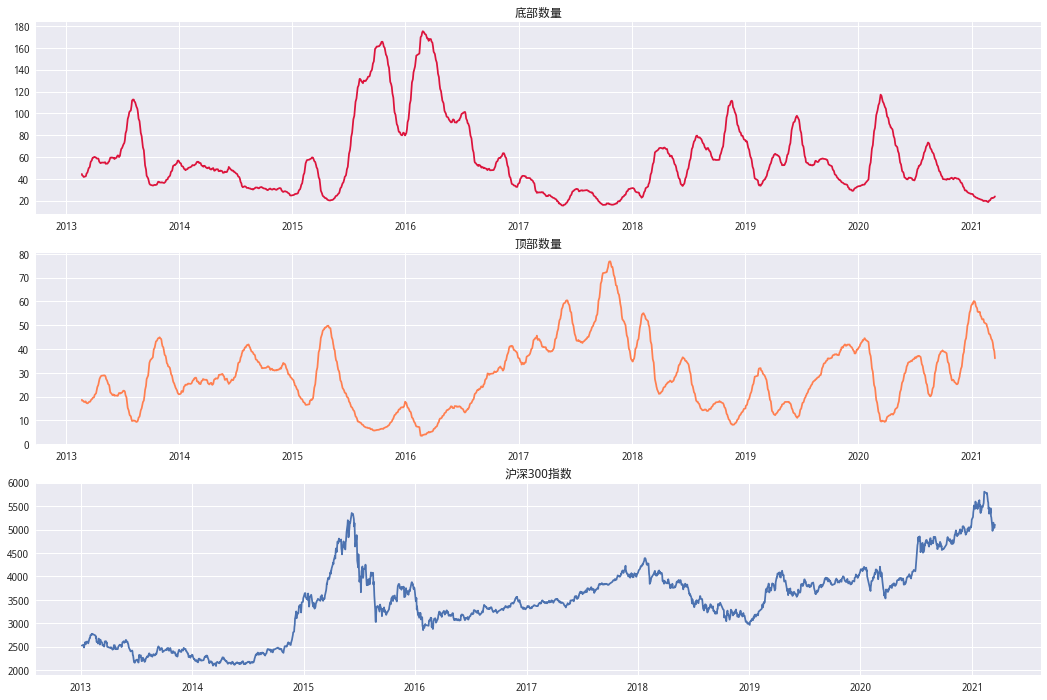

In [10]:
# 直接统计数量
plt.rcParams['font.family'] = 'serif'
fig,axes = plt.subplots(3,figsize=(18,4 * 3))

axes[0].set_title('底部数量')
axes[0].plot(bottom_ser.rolling(30).mean(),color='Crimson',label='MA30')

axes[1].set_title('顶部数量')
axes[1].plot(top_ser.rolling(30).mean(),color='Coral',label='MA30')

axes[2].set_title('沪深300指数')
axes[2].plot(benchmark['close'])

将两个组合做差,可以看到拐点与指数有一定的预见性。

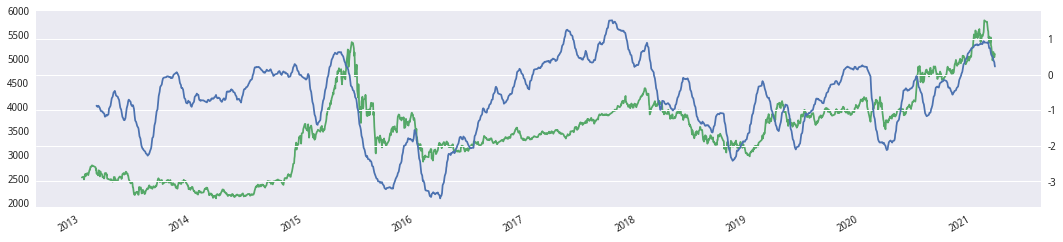

In [11]:
N = 30
# 信号对数化方便做差
log_bottom = np.log(talib.EMA(bottom_ser,N))
log_top = np.log(talib.EMA(top_ser,N))

diff_signal = log_top - log_bottom # 差值
line = diff_signal.plot(figsize=(18,4),secondary_y=True)
benchmark['close'].plot(ax=line)

In [12]:
# 信号双均线
flag = diff_signal - talib.EMA(diff_signal,10)
flag = (flag > 0) * 1

next_ret = benchmark['close'].pct_change().shift(-1)
algorithm_ret = flag * next_ret
cumRet = 1 + ep.cum_returns(algorithm_ret)

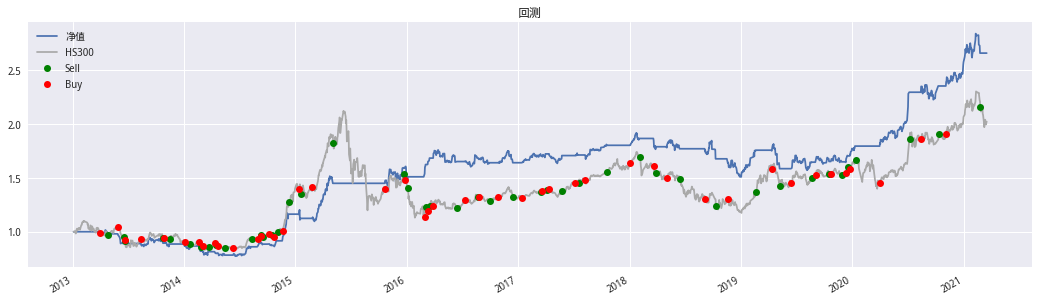

In [13]:
trade_info = tradeAnalyze(flag,next_ret) # 初始化交易信息
# 画图
cumRet.plot(figsize=(18,5),label='净值',title='回测')

(benchmark['close'] / benchmark['close'][0]).plot(color='darkgray',label='HS300')

plot_trade_pos(trade_info,benchmark['close'] / benchmark['close'][0])

plt.legend()

In [14]:
# 风险指标
Strategy_performance(algorithm_ret,'daily').style.format('{:.2%}')

,ret
年化收益率,13.15%
波动率,13.94%
夏普,95.63%
最大回撤,-23.85%


In [15]:
# 展示交易明细
trade_info.show_all()

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.85,2013-04-18,2014-06-18,2014-11-28,422
1,21.25,2018-01-23,2019-01-02,2020-04-30,593
2,8.87,2015-01-15,2015-03-05,2015-03-17,44
3,8.87,2016-04-13,2016-07-29,2017-08-25,358
4,7.86,2015-12-29,2015-12-31,2016-03-03,48


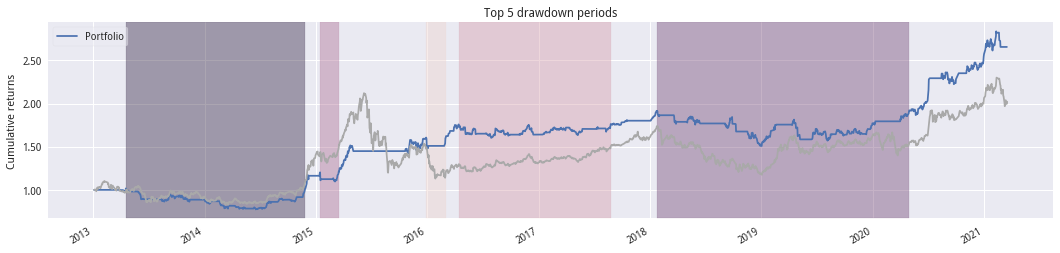

In [16]:
show_worst_drawdown_periods(algorithm_ret)
fig,ax = plt.subplots(figsize=(18,4))
plot_drawdown_periods(algorithm_ret,5,ax)
ax.plot(benchmark['close'] / benchmark['close'][0],color='darkgray')

### 寻找最优参数

使用sklearn将上述过程打包,并使用RandomizedSearchCV进行寻参。

In [9]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from typing import Callable

# 构造趋势指标构建
class creatSignal_a(TransformerMixin, BaseEstimator):

    def __init__(self, creatperiod: int,creatfunc:Callable)->None:
        '''
        createperiod:头部-顶部的数量周期
        creatfunc:均线计算方法函数
        '''
        self.creatperiod = creatperiod
        self.creatfunc = creatfunc

    def fit(self, factor_df:pd.Series, returns=None):

        return self

    def transform(self, factor_df:pd.DataFrame)->pd.Series:

        # 每日分组
        rank_df = factor_df.apply(pd.cut,bins=5,labels=['G%s'%i for i in range(1,6)],axis=1)
        
        bottom_ser = (rank_df == 'G1').sum(axis=1) 
        top_ser = (rank_df == 'G5').sum(axis=1)
        
        log_bottom = np.log(self.creatfunc(bottom_ser,self.creatperiod))
        log_top = np.log(self.creatfunc(top_ser,self.creatperiod))

        diff_signal = log_top - log_bottom # 差值
        
        return diff_signal.dropna()

    
# 策略构建
class AlgorthmStrategy_a(BaseEstimator):

    def __init__(self, window:int,mafunc:Callable)->None:

        self.window = window
        self.mafunc = mafunc
            
    # 策略是如何训练的
    def fit(self, signal:pd.Series, returns:pd.Series)->pd.Series:
        '''
        signal:信号数据
        returns:收益数据
        '''
        idx = signal.index
        algorithm_ret = self.predict(signal) * returns.shift(-1).reindex(idx)
        return algorithm_ret.dropna()

    # 策略如何进行信号生成
    def predict(self, signal:pd.Series)->pd.Series:
        
        '''singal:信号数据'''
        
        longSignal = self.mafunc(signal,self.window)
        diffSeries = signal - longSignal # 双均线信号
        
        return (diffSeries > 0) * 1

    # 如何判断策略是优是劣质
    def score(self, signal:pd.Series, returns:pd.Series)->float:
        '''本质上是设置一个目标函数'''
        ret = self.fit(signal, returns)

        # 优化指标为： 卡玛比率 + 夏普
        # 分数越大越好
        
        risk = ep.calmar_ratio(ret) + ep.sharpe_ratio(ret)
        
        return risk

In [14]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# 回测时间设置
startDt = factor_df.index.min().strftime('%Y-%m-%d')
endDt = factor_df.index.max().strftime('%Y-%m-%d')

# 基准
benchmark = get_price('000300.XSHG',startDt,endDt,fields='close',panel=False)

returns = benchmark['close'].pct_change().reindex(factor_df.index)

# 构造PIPELINE
ivr_timing = Pipeline([('creatSignal', creatSignal_a(30, talib.SMA)),
                         ('backtesting', AlgorthmStrategy_a(5, talib.SMA))])

# 寻参范围设置
## 阈值

randint = st.randint(low=3, high=150)
window_randint = st.randint(low=2,high=60)

# 超参设置
param_grid = {'creatSignal__creatperiod': randint,
              'backtesting__window': window_randint
             }


grid_search = RandomizedSearchCV(
    ivr_timing, param_grid, n_iter=100, verbose=2, n_jobs=3,random_state=42)

grid_search.fit(factor_df, returns)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] backtesting__window=40, creatSignal__creatperiod=95 .............
[CV] backtesting__window=40, creatSignal__creatperiod=95 .............
[CV] backtesting__window=40, creatSignal__creatperiod=95 .............
[CV]  backtesting__window=40, creatSignal__creatperiod=95, total=   4.9s
[CV] backtesting__window=16, creatSignal__creatperiod=109 ............
[CV]  backtesting__window=40, creatSignal__creatperiod=95, total=   4.9s
[CV] backtesting__window=16, creatSignal__creatperiod=109 ............
[CV]  backtesting__window=40, creatSignal__creatperiod=95, total=   5.2s
[CV] backtesting__window=16, creatSignal__creatperiod=109 ............
[CV]  backtesting__window=16, creatSignal__creatperiod=109, total=   5.2s
[CV] backtesting__window=9, creatSignal__creatperiod=23 ..............
[CV]  backtesting__window=16, creatSignal__creatperiod=109, total=   5.1s
[CV] backtesting__window=9, creatSignal__creatperiod=23 ..............
[C

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.7min


[CV]  backtesting__window=3, creatSignal__creatperiod=23, total=   5.3s
[CV] backtesting__window=34, creatSignal__creatperiod=60 .............
[CV]  backtesting__window=34, creatSignal__creatperiod=60, total=   4.9s
[CV] backtesting__window=23, creatSignal__creatperiod=91 .............
[CV]  backtesting__window=34, creatSignal__creatperiod=60, total=   5.1s
[CV] backtesting__window=23, creatSignal__creatperiod=91 .............
[CV]  backtesting__window=34, creatSignal__creatperiod=60, total=   5.0s
[CV] backtesting__window=23, creatSignal__creatperiod=91 .............
[CV]  backtesting__window=23, creatSignal__creatperiod=91, total=   4.9s
[CV] backtesting__window=50, creatSignal__creatperiod=61 .............
[CV]  backtesting__window=23, creatSignal__creatperiod=91, total=   4.9s
[CV] backtesting__window=50, creatSignal__creatperiod=61 .............
[CV]  backtesting__window=23, creatSignal__creatperiod=91, total=   4.9s
[CV] backtesting__window=50, creatSignal__creatperiod=61 .......

[CV]  backtesting__window=15, creatSignal__creatperiod=83, total=   4.9s
[CV] backtesting__window=37, creatSignal__creatperiod=52 .............
[CV]  backtesting__window=37, creatSignal__creatperiod=52, total=   5.0s
[CV] backtesting__window=41, creatSignal__creatperiod=134 ............
[CV]  backtesting__window=37, creatSignal__creatperiod=52, total=   4.8s
[CV] backtesting__window=41, creatSignal__creatperiod=134 ............
[CV]  backtesting__window=37, creatSignal__creatperiod=52, total=   5.0s
[CV] backtesting__window=41, creatSignal__creatperiod=134 ............
[CV]  backtesting__window=41, creatSignal__creatperiod=134, total=   4.8s
[CV] backtesting__window=3, creatSignal__creatperiod=136 .............
[CV]  backtesting__window=41, creatSignal__creatperiod=134, total=   4.7s
[CV] backtesting__window=3, creatSignal__creatperiod=136 .............
[CV]  backtesting__window=41, creatSignal__creatperiod=134, total=   4.8s
[CV] backtesting__window=3, creatSignal__creatperiod=136 ...

[CV]  backtesting__window=2, creatSignal__creatperiod=138, total=   4.9s
[CV] backtesting__window=25, creatSignal__creatperiod=65 .............
[CV]  backtesting__window=25, creatSignal__creatperiod=65, total=   5.0s
[CV] backtesting__window=12, creatSignal__creatperiod=83 .............
[CV]  backtesting__window=25, creatSignal__creatperiod=65, total=   5.1s
[CV] backtesting__window=12, creatSignal__creatperiod=83 .............
[CV]  backtesting__window=25, creatSignal__creatperiod=65, total=   4.9s
[CV] backtesting__window=12, creatSignal__creatperiod=83 .............
[CV]  backtesting__window=12, creatSignal__creatperiod=83, total=   4.9s
[CV] backtesting__window=9, creatSignal__creatperiod=35 ..............
[CV]  backtesting__window=12, creatSignal__creatperiod=83, total=   5.2s
[CV] backtesting__window=9, creatSignal__creatperiod=35 ..............
[CV]  backtesting__window=12, creatSignal__creatperiod=83, total=   5.0s
[CV] backtesting__window=9, creatSignal__creatperiod=35 .......

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  7.3min


[CV]  backtesting__window=9, creatSignal__creatperiod=35, total=   5.2s
[CV] backtesting__window=6, creatSignal__creatperiod=43 ..............
[CV]  backtesting__window=9, creatSignal__creatperiod=35, total=   5.1s
[CV] backtesting__window=6, creatSignal__creatperiod=43 ..............
[CV]  backtesting__window=9, creatSignal__creatperiod=35, total=   5.0s
[CV] backtesting__window=6, creatSignal__creatperiod=43 ..............
[CV]  backtesting__window=6, creatSignal__creatperiod=43, total=   5.1s
[CV] backtesting__window=29, creatSignal__creatperiod=137 ............
[CV]  backtesting__window=6, creatSignal__creatperiod=43, total=   5.1s
[CV] backtesting__window=29, creatSignal__creatperiod=137 ............
[CV]  backtesting__window=6, creatSignal__creatperiod=43, total=   4.9s
[CV] backtesting__window=29, creatSignal__creatperiod=137 ............
[CV]  backtesting__window=29, creatSignal__creatperiod=137, total=   5.0s
[CV] backtesting__window=10, creatSignal__creatperiod=74 ...........

[CV]  backtesting__window=31, creatSignal__creatperiod=145, total=   5.1s
[CV] backtesting__window=44, creatSignal__creatperiod=31 .............
[CV]  backtesting__window=31, creatSignal__creatperiod=145, total=   5.3s
[CV] backtesting__window=44, creatSignal__creatperiod=31 .............
[CV]  backtesting__window=31, creatSignal__creatperiod=145, total=   5.2s
[CV] backtesting__window=44, creatSignal__creatperiod=31 .............
[CV]  backtesting__window=44, creatSignal__creatperiod=31, total=   5.2s
[CV] backtesting__window=37, creatSignal__creatperiod=15 .............
[CV]  backtesting__window=44, creatSignal__creatperiod=31, total=   5.2s
[CV] backtesting__window=37, creatSignal__creatperiod=15 .............
[CV]  backtesting__window=44, creatSignal__creatperiod=31, total=   5.1s
[CV] backtesting__window=37, creatSignal__creatperiod=15 .............
[CV]  backtesting__window=37, creatSignal__creatperiod=15, total=   5.4s
[CV] backtesting__window=33, creatSignal__creatperiod=73 ...

[CV]  backtesting__window=43, creatSignal__creatperiod=61, total=   5.0s
[CV] backtesting__window=55, creatSignal__creatperiod=98 .............
[CV]  backtesting__window=43, creatSignal__creatperiod=61, total=   5.3s
[CV] backtesting__window=55, creatSignal__creatperiod=98 .............
[CV]  backtesting__window=43, creatSignal__creatperiod=61, total=   5.0s
[CV] backtesting__window=55, creatSignal__creatperiod=98 .............
[CV]  backtesting__window=55, creatSignal__creatperiod=98, total=   5.1s
[CV] backtesting__window=25, creatSignal__creatperiod=115 ............
[CV]  backtesting__window=55, creatSignal__creatperiod=98, total=   4.8s
[CV] backtesting__window=25, creatSignal__creatperiod=115 ............
[CV]  backtesting__window=55, creatSignal__creatperiod=98, total=   5.0s
[CV] backtesting__window=25, creatSignal__creatperiod=115 ............
[CV]  backtesting__window=25, creatSignal__creatperiod=115, total=   5.3s
[CV] backtesting__window=50, creatSignal__creatperiod=54 .....

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 14.0min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('creatSignal', creatSignal_a(creatfunc=<function SMA at 0x7fbdfd568950>, creatperiod=30)), ('backtesting', AlgorthmStrategy_a(mafunc=<function SMA at 0x7fbdfd568950>, window=5))]),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'creatSignal__creatperiod': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdd27d0438>, 'backtesting__window': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdcef82c18>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [15]:
# 最优参数
grid_search.best_params_

{'backtesting__window': 44, 'creatSignal__creatperiod': 31}

**回测**

金叉买入,死叉卖出

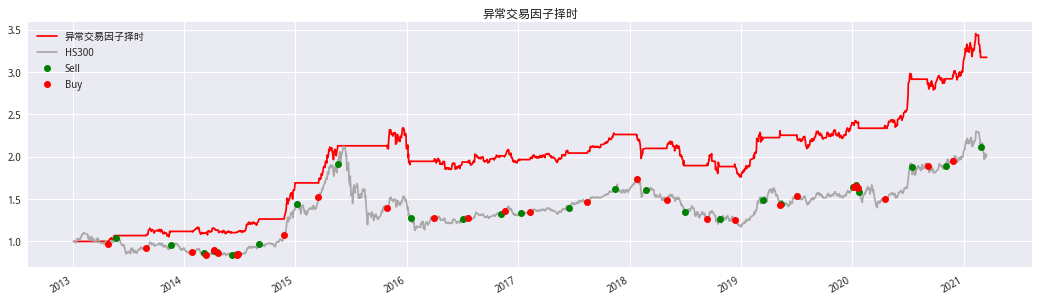

In [16]:
# 使用最优参数构建开平仓 使用最优估计
flag = grid_search.best_estimator_.predict(factor_df)
next_ret = returns.shift(-1)
# 计算收益率
algorithm_ret = flag * next_ret

trade_info = tradeAnalyze(flag,next_ret) # 初始化交易信息

mpl.rcParams['font.family'] = 'serif'

# 画图
(1 + ep.cum_returns(algorithm_ret)).plot(
     figsize=(18, 5), label='异常交易因子择时',title='异常交易因子择时',color='r')
    
(benchmark['close'] / benchmark['close'][0]).plot(label='HS300',color='darkgray')
plot_trade_pos(trade_info,benchmark['close'] / benchmark['close'][0])
plt.legend()

In [17]:
# 风险指标
Strategy_performance(algorithm_ret,'daily').style.format('{:.2%}')

,ret
年化收益率,15.72%
波动率,14.47%
夏普,109.78%
最大回撤,-24.75%


In [18]:
# 展示交易明细
trade_info.show_all()

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.75,2015-12-21,2019-01-02,2019-12-27,1050
1,8.75,2013-09-11,2013-11-12,2014-02-13,112
2,8.11,2021-02-09,2021-02-25,NaT,NaN
3,7.56,2014-02-14,2014-03-19,2014-07-24,115
4,7.38,2015-11-06,2015-11-26,2015-12-18,31


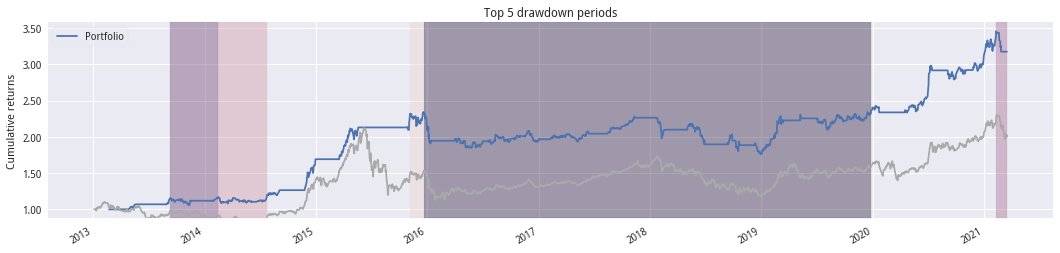

In [19]:
show_worst_drawdown_periods(algorithm_ret.dropna())
fig,ax = plt.subplots(figsize=(18,4))
plot_drawdown_periods(algorithm_ret.dropna(),5,ax)
ax.plot(benchmark['close'] / benchmark['close'][0],color='darkgray')

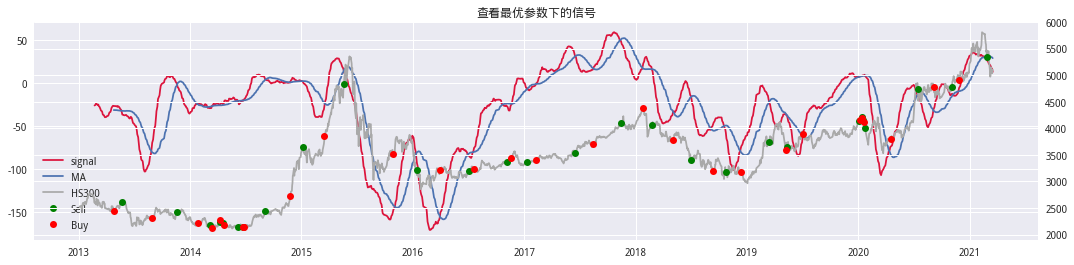

In [25]:
# 查看信号
fig,ax = plt.subplots(figsize=(18,4))

ax.set_title('查看最优参数下的信号')
N = grid_search.best_params_['creatSignal__creatperiod']
M = grid_search.best_params_['backtesting__window']
ser = top_ser.rolling(N).mean() - bottom_ser.rolling(N).mean()
ma = ser.rolling(M).mean()

ax.plot(ser,color='Crimson',label='signal')
ax.plot(ma,label='MA')
ax1 = ax.twinx()
ax1.plot(benchmark['close'],label='HS300',color='darkgray')
plot_trade_pos(trade_info,benchmark['close'],ax=ax1)

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax1.get_legend_handles_labels()
ax.legend(h1+h2,l1+l2)
plt.grid(False)

## 构思二：

1. 构建数量剪刀差_快线:因子升序分五组,头部组合数量N日移动平均-底部组合数量N日移动平均
2. 构建数量剪刀差_慢线:因子升序分五组,头部组合数量M日移动平均-底部组合数量M日移动平均
3. 快线与第慢均线形成双均线

其中:M>N

In [10]:
# 构造趋势指标构建
class creatSignal_b(TransformerMixin, BaseEstimator):

    def __init__(self, longperiod: int,shortperiod:int,creatfunc:Callable)->None:
        '''
        createperiod:头部-顶部的数量周期
        creatfunc:均线计算方法函数
        '''
        self.longperiod = longperiod
        self.shortperiod = shortperiod
        self.creatfunc = creatfunc

    def fit(self, factor_df:pd.Series, returns=None):

        return self

    def transform(self, factor_df:pd.DataFrame)->pd.Series:

        # 每日分组
        rank_df = factor_df.apply(pd.cut,bins=5,labels=['G%s'%i for i in range(1,6)],axis=1)
        
        bottom_ser = (rank_df == 'G1').sum(axis=1) 
        top_ser = (rank_df == 'G5').sum(axis=1)
        
        def buildSignal(top_ser:pd.Series,bottom_ser:pd.Series,N:int)->pd.Series:
            
            log_bottom = np.log(self.creatfunc(bottom_ser,N))
            log_top = np.log(self.creatfunc(top_ser,N))

            diff_signal = log_top - log_bottom # 差值
            return diff_signal.dropna()
            
        long = buildSignal(top_ser,bottom_ser,self.longperiod)
        short = buildSignal(top_ser,bottom_ser,self.shortperiod)
        
        signal = ((long - short) > 0) * 1
        
        return signal

    
# 策略构建
class AlgorthmStrategy_b(BaseEstimator):

    def __init__(self)->None:

        pass
            
    # 策略是如何训练的
    def fit(self, signal:pd.Series, returns:pd.Series)->pd.Series:
        '''
        signal:信号数据
        returns:收益数据
        '''
        idx = signal.index
        # 收益率滞后一期
        algorithm_ret = self.predict(signal) * returns.shift(-1).reindex(idx)
        return algorithm_ret.dropna()

    # 策略如何进行信号生成
    def predict(self, signal:pd.Series)->pd.Series:
        
        '''singal:信号数据'''
        
        
        return signal

    # 如何判断策略是优是劣质
    def score(self, signal:pd.Series, returns:pd.Series)->float:

        ret = self.fit(signal, returns)

        # 优化指标为： 卡玛比率 + 夏普
        # 分数越大越好
        
        risk = ep.calmar_ratio(ret) + ep.sharpe_ratio(ret)
        
        return risk

### 寻找最优参数

**回测**

金叉买入,死叉卖出

In [30]:
# 回测时间设置
startDt = factor_df.index.min().strftime('%Y-%m-%d')
endDt = factor_df.index.max().strftime('%Y-%m-%d')

# 基准
benchmark = get_price('000300.XSHG',startDt,endDt,fields='close',panel=False)


returns = benchmark['close'].pct_change().reindex(factor_df.index)

# 构造PIPELINE
ivr_timing = Pipeline([('creatSignal', creatSignal_b(5,30, talib.SMA)),
                         ('backtesting', AlgorthmStrategy_b())])

# 寻参范围设置
## 阈值

randint = st.randint(low=3, high=150)

# 超参设置
param_grid = {'creatSignal__longperiod': randint,
              'creatSignal__shortperiod': randint
             }


grid_search = RandomizedSearchCV(
    ivr_timing, param_grid, n_iter=100, verbose=2, n_jobs=3,random_state=42)

grid_search.fit(factor_df, returns)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] creatSignal__longperiod=105, creatSignal__shortperiod=95 ........
[CV] creatSignal__longperiod=105, creatSignal__shortperiod=95 ........
[CV] creatSignal__longperiod=105, creatSignal__shortperiod=95 ........
[CV]  creatSignal__longperiod=105, creatSignal__shortperiod=95, total=   5.1s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=109 ........
[CV]  creatSignal__longperiod=105, creatSignal__shortperiod=95, total=   5.4s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=109 ........
[CV]  creatSignal__longperiod=105, creatSignal__shortperiod=95, total=   5.5s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=109 ........
[CV]  creatSignal__longperiod=17, creatSignal__shortperiod=109, total=   5.1s
[CV] creatSignal__longperiod=74, creatSignal__shortperiod=23 .........
[CV]  creatSignal__longperiod=17, creatSignal__shortperiod=109, total=   5.1s
[CV]  creatSignal__longperiod=17, creatSignal__sho

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.8min


[CV]  creatSignal__longperiod=91, creatSignal__shortperiod=51, total=   5.1s
[CV] creatSignal__longperiod=61, creatSignal__shortperiod=17 .........
[CV]  creatSignal__longperiod=61, creatSignal__shortperiod=17, total=   5.0s
[CV] creatSignal__longperiod=53, creatSignal__shortperiod=110 ........
[CV]  creatSignal__longperiod=61, creatSignal__shortperiod=17, total=   5.0s
[CV] creatSignal__longperiod=53, creatSignal__shortperiod=110 ........
[CV]  creatSignal__longperiod=61, creatSignal__shortperiod=17, total=   5.1s
[CV] creatSignal__longperiod=53, creatSignal__shortperiod=110 ........
[CV]  creatSignal__longperiod=53, creatSignal__shortperiod=110, total=   5.2s
[CV] creatSignal__longperiod=57, creatSignal__shortperiod=66 .........
[CV]  creatSignal__longperiod=53, creatSignal__shortperiod=110, total=   4.9s
[CV] creatSignal__longperiod=57, creatSignal__shortperiod=66 .........
[CV]  creatSignal__longperiod=53, creatSignal__shortperiod=110, total=   5.2s
[CV] creatSignal__longperiod=57,

[CV] creatSignal__longperiod=97, creatSignal__shortperiod=50 .........
[CV]  creatSignal__longperiod=46, creatSignal__shortperiod=16, total=   4.9s
[CV] creatSignal__longperiod=97, creatSignal__shortperiod=50 .........
[CV]  creatSignal__longperiod=46, creatSignal__shortperiod=16, total=   5.2s
[CV] creatSignal__longperiod=97, creatSignal__shortperiod=50 .........
[CV]  creatSignal__longperiod=97, creatSignal__shortperiod=50, total=   5.3s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=42 .........
[CV]  creatSignal__longperiod=97, creatSignal__shortperiod=50, total=   5.0s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=42 .........
[CV]  creatSignal__longperiod=97, creatSignal__shortperiod=50, total=   5.0s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=42 .........
[CV]  creatSignal__longperiod=17, creatSignal__shortperiod=42, total=   4.9s
[CV] creatSignal__longperiod=84, creatSignal__shortperiod=113 ........
[CV]  creatSignal__longperiod=17, creatSi

[CV]  creatSignal__longperiod=39, creatSignal__shortperiod=101, total=   6.7s
[CV] creatSignal__longperiod=106, creatSignal__shortperiod=37 ........
[CV]  creatSignal__longperiod=106, creatSignal__shortperiod=37, total=   6.8s
[CV] creatSignal__longperiod=103, creatSignal__shortperiod=133 .......
[CV]  creatSignal__longperiod=106, creatSignal__shortperiod=37, total=   6.7s
[CV] creatSignal__longperiod=103, creatSignal__shortperiod=133 .......
[CV]  creatSignal__longperiod=106, creatSignal__shortperiod=37, total=   6.9s
[CV] creatSignal__longperiod=103, creatSignal__shortperiod=133 .......
[CV]  creatSignal__longperiod=103, creatSignal__shortperiod=133, total=   6.9s
[CV] creatSignal__longperiod=3, creatSignal__shortperiod=7 ...........
[CV]  creatSignal__longperiod=103, creatSignal__shortperiod=133, total=   6.8s
[CV] creatSignal__longperiod=3, creatSignal__shortperiod=7 ...........
[CV]  creatSignal__longperiod=103, creatSignal__shortperiod=133, total=   7.0s
[CV] creatSignal__longper

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  7.7min


[CV]  creatSignal__longperiod=144, creatSignal__shortperiod=105, total=   6.9s
[CV] creatSignal__longperiod=29, creatSignal__shortperiod=139 ........
[CV]  creatSignal__longperiod=144, creatSignal__shortperiod=105, total=   7.1s
[CV] creatSignal__longperiod=29, creatSignal__shortperiod=139 ........
[CV]  creatSignal__longperiod=144, creatSignal__shortperiod=105, total=   6.8s
[CV] creatSignal__longperiod=29, creatSignal__shortperiod=139 ........
[CV]  creatSignal__longperiod=29, creatSignal__shortperiod=139, total=   7.0s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=92 .........
[CV]  creatSignal__longperiod=29, creatSignal__shortperiod=139, total=   7.1s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=92 .........
[CV]  creatSignal__longperiod=29, creatSignal__shortperiod=139, total=   7.1s
[CV] creatSignal__longperiod=17, creatSignal__shortperiod=92 .........
[CV]  creatSignal__longperiod=17, creatSignal__shortperiod=92, total=   7.2s
[CV] creatSignal__longperi

[CV] creatSignal__longperiod=5, creatSignal__shortperiod=105 .........
[CV]  creatSignal__longperiod=123, creatSignal__shortperiod=118, total=   5.7s
[CV] creatSignal__longperiod=5, creatSignal__shortperiod=105 .........
[CV]  creatSignal__longperiod=5, creatSignal__shortperiod=105, total=   5.2s
[CV] creatSignal__longperiod=139, creatSignal__shortperiod=64 ........
[CV]  creatSignal__longperiod=5, creatSignal__shortperiod=105, total=   5.1s
[CV] creatSignal__longperiod=139, creatSignal__shortperiod=64 ........
[CV]  creatSignal__longperiod=5, creatSignal__shortperiod=105, total=   5.4s
[CV] creatSignal__longperiod=139, creatSignal__shortperiod=64 ........
[CV]  creatSignal__longperiod=139, creatSignal__shortperiod=64, total=   5.1s
[CV] creatSignal__longperiod=53, creatSignal__shortperiod=61 .........
[CV]  creatSignal__longperiod=139, creatSignal__shortperiod=64, total=   4.8s
[CV] creatSignal__longperiod=53, creatSignal__shortperiod=61 .........
[CV]  creatSignal__longperiod=139, cr

[CV]  creatSignal__longperiod=100, creatSignal__shortperiod=141, total=   5.1s
[CV] creatSignal__longperiod=146, creatSignal__shortperiod=99 ........
[CV]  creatSignal__longperiod=100, creatSignal__shortperiod=141, total=   5.3s
[CV] creatSignal__longperiod=146, creatSignal__shortperiod=99 ........
[CV]  creatSignal__longperiod=100, creatSignal__shortperiod=141, total=   5.1s
[CV] creatSignal__longperiod=146, creatSignal__shortperiod=99 ........
[CV]  creatSignal__longperiod=146, creatSignal__shortperiod=99, total=   5.1s
[CV] creatSignal__longperiod=126, creatSignal__shortperiod=72 ........
[CV]  creatSignal__longperiod=146, creatSignal__shortperiod=99, total=   5.3s
[CV] creatSignal__longperiod=126, creatSignal__shortperiod=72 ........
[CV]  creatSignal__longperiod=146, creatSignal__shortperiod=99, total=   5.3s
[CV] creatSignal__longperiod=126, creatSignal__shortperiod=72 ........
[CV]  creatSignal__longperiod=126, creatSignal__shortperiod=72, total=   4.8s
[CV] creatSignal__longper

[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 15.2min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('creatSignal', creatSignal_b(creatfunc=<function SMA at 0x7fbdfd568950>, longperiod=5,
       shortperiod=30)), ('backtesting', AlgorthmStrategy_b())]),
          fit_params=None, iid=True, n_iter=100, n_jobs=3,
          param_distributions={'creatSignal__longperiod': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdced98f98>, 'creatSignal__shortperiod': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdced98f98>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [31]:
# 最优参数
grid_search.best_params_

{'creatSignal__longperiod': 17, 'creatSignal__shortperiod': 109}

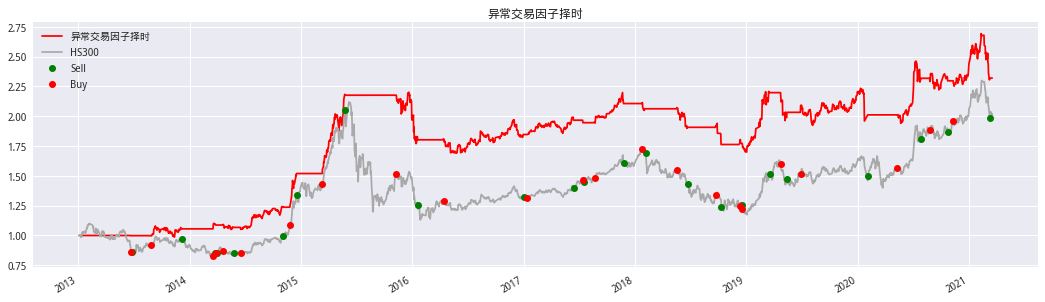

In [32]:
# 使用最优参数构建开平仓 使用最优估计
flag = grid_search.best_estimator_.predict(factor_df)
next_ret = returns.shift(-1)
# 计算收益率
algorithm_ret = flag * next_ret

trade_info = tradeAnalyze(flag,next_ret) # 初始化交易信息

mpl.rcParams['font.family'] = 'serif'

# 画图
(1 + ep.cum_returns(algorithm_ret)).plot(
     figsize=(18, 5), label='异常交易因子择时',title='异常交易因子择时',color='r')
    
(benchmark['close'] / benchmark['close'][0]).plot(label='HS300',color='darkgray')
plot_trade_pos(trade_info,benchmark['close'] / benchmark['close'][0])

plt.legend()

In [33]:
# 风险指标
Strategy_performance(algorithm_ret,'daily').style.format('{:.2%}')

,ret
年化收益率,11.23%
波动率,14.68%
夏普,80.54%
最大回撤,-23.19%


In [34]:
# 展示交易明细
trade_info.show_all()

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.19,2015-12-21,2016-05-24,2019-03-05,837
1,14.41,2021-02-09,2021-03-08,NaT,NaN
2,13.12,2020-01-10,2020-05-21,2020-07-02,125
3,12.86,2019-03-15,2019-08-06,2020-01-06,212
4,9.80,2020-07-10,2020-09-23,2021-01-04,127


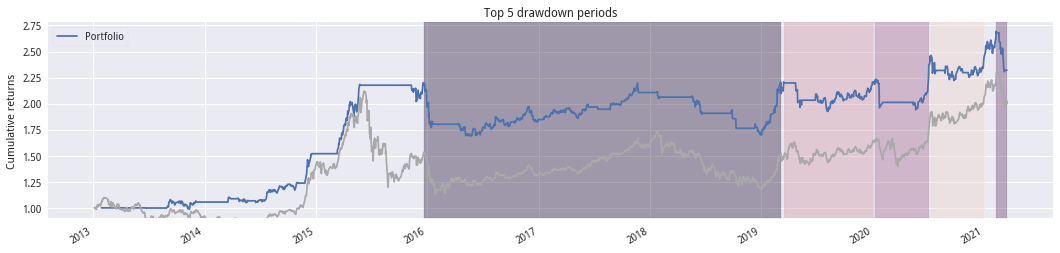

In [35]:
show_worst_drawdown_periods(algorithm_ret.dropna())
fig,ax = plt.subplots(figsize=(18,4))
plot_drawdown_periods(algorithm_ret.dropna(),5,ax)
ax.plot(benchmark['close'] / benchmark['close'][0],color='darkgray')

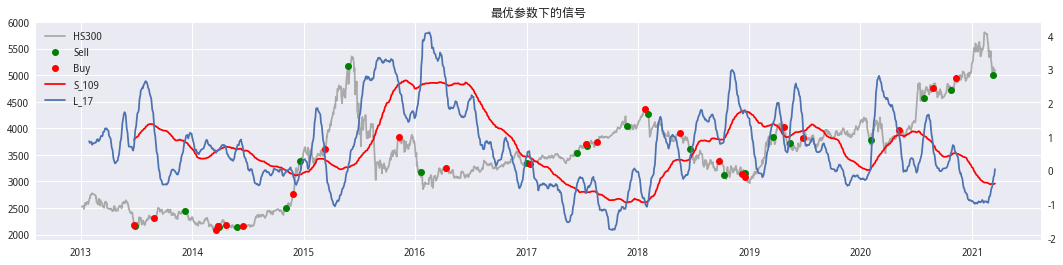

In [39]:
# 查看信号
S = grid_search.best_params_['creatSignal__shortperiod']
L = grid_search.best_params_['creatSignal__longperiod']

log_bottom_30 = np.log(bottom_ser.rolling(S).mean())
log_top_30 = np.log(top_ser.rolling(S).mean())

log_bottom_60 = np.log(bottom_ser.rolling(L).mean())
log_top_60 = np.log(top_ser.rolling(L).mean())

# 差值
diff_signal_30 = log_bottom_30 - log_top_30 
diff_signal_60 = log_bottom_60 - log_top_60

fig,ax = plt.subplots(figsize=(18,4))
ax.set_title('最优参数下的信号')
ax.plot(benchmark['close'],label='HS300',color='darkgray')
plot_trade_pos(trade_info,benchmark['close'],ax=ax)

ax1 = ax.twinx()
ax1.plot(diff_signal_30,label='S_' + str(S),color='r')
ax1.plot(diff_signal_60,label='L_' + str(L))

h1,l1 = ax.get_legend_handles_labels()
h2,l2 = ax1.get_legend_handles_labels()
ax.legend(h1+h2,l1+l2)
plt.grid(False)

## 构思三:

以头部/底部因子组合因子值为信号

In [13]:
# 信号获取
top_factor_val = factor_df[rank_df=='G5'].mean(axis=1)
bottom_factor_val = factor_df[rank_df=='G1'].mean(axis=1)

查看信号与指数的关系

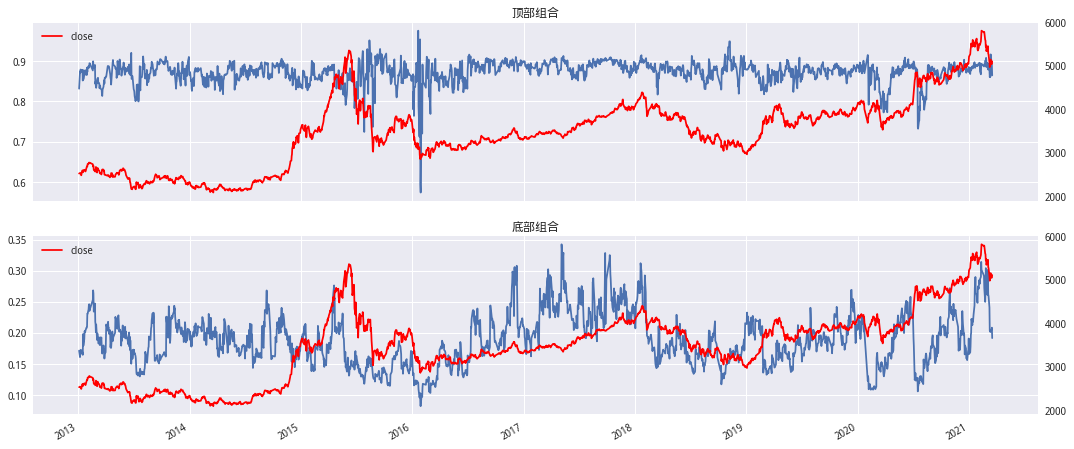

In [105]:
# 时间设置
startDt = top_factor_val.index.min().strftime('%Y-%m-%d')
endDt = top_factor_val.index.max().strftime('%Y-%m-%d')

# 基准
benchmark = get_price('000300.XSHG',startDt,endDt,fields='close',panel=False)

fig,axes = plt.subplots(2,figsize=(18,4 * 2))

axes[0].set_title('顶部组合')
top_factor_val.plot(ax=axes[0])
ax1 = axes[0].twinx()
benchmark.plot(ax=ax1,color='r')
plt.grid(False)

axes[1].set_title('底部组合')
bottom_factor_val.plot(ax=axes[1])
ax1 = axes[1].twinx()
benchmark.plot(ax=ax1,color='r')
plt.grid(False)

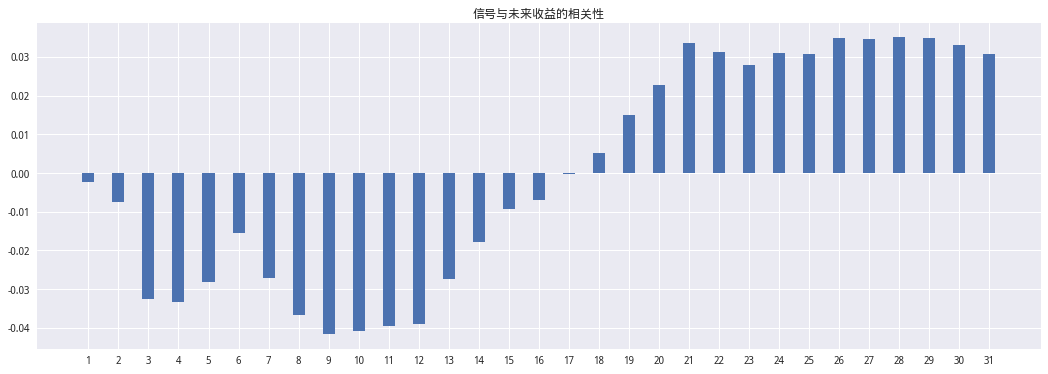

In [267]:
show_corrocef(benchmark['close'],signal_df['signal'],'信号与未来收益的相关性')

**构造信号**:计算N日标准分,以标准分为信号进行择时

In [139]:
# 标准分 
N = 120
signal = (top_factor_val - top_factor_val.rolling(N).mean()) / top_factor_val.rolling(N).std()
signal.describe()

count    1874.000000
mean       -0.011293
std         1.096084
min        -5.951681
25%        -0.592134
50%         0.175104
75%         0.725229
max         3.561617
dtype: float64

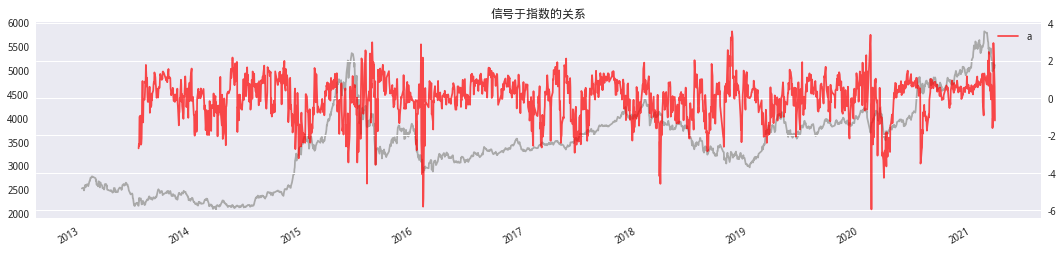

In [199]:
line = signal.plot(secondary_y=True,
                   figsize=(18,4),color='r',
                   title='信号于指数的关系',
                   alpha=0.7,
                  label='标准分信号')
benchmark['close'].plot(ax=line,color='darkgray',label='HS300')
plt.legend()

**回测构建**

信号大于h值开仓,小于l值平仓

In [157]:
# 标记持仓
def get_pos(signal:pd.Series,h:float,l:float)->pd.Series:
    
    '''
    高于h时开仓,低于l时平仓,1为持仓,0为空仓
    -------
        signal:信号 index-date,value-信号
        h,l:高低阈值
    '''
    
    per_signal = signal.shift(1)
    per_pos = 0
    pos = pd.Series(np.ones(len(signal)),index=signal.index)
    
    for trade,v in signal.items():
        
        per = per_signal[trade]
      
        if per:
            
            if v > h and per <= h:
               
                pos[trade] = 1
                per_pos = 1
                
            elif v < l and per >= l:
              
                pos[trade] = 0
                per_pos = 0
                
            else:
               
                pos[trade] = per_pos
                
        else:
            
            if v > h:
                pos[trade] = 1
                per_pos = 1
                
            elif v < l:
                
                pos[trade] = 0
                per_pos = 0
                
            else:
                
                pos[trade] = 0
                
    return pos
            

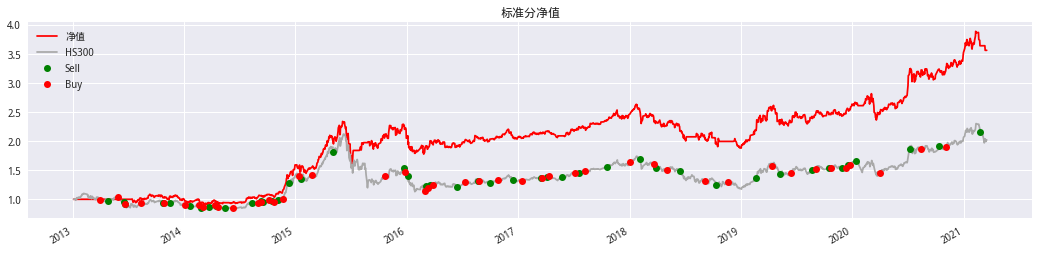

In [219]:
# 开仓阈值-1,2
pos = get_pos(signal,-1, 2)
next_ret = benchmark['close'].pct_change().shift(-1)

trade_info = tradeAnalyze(flag,next_ret) # 初始化交易信息

algorithm_ret = pos * next_ret
(1 + ep.cum_returns(algorithm_ret)).plot(figsize=(18,4),color='r',title='回测',label='净值')
(benchmark['close'] / benchmark['close'][0]).plot(color='darkgray',label='HS300')
plot_trade_pos(trade_info,benchmark['close'] / benchmark['close'][0])
plt.legend()

In [211]:
# 风险指标
Strategy_performance(algorithm_ret,'daily').style.format('{:.2%}')

,ret
年化收益率,13.15%
波动率,13.94%
夏普,95.63%
最大回撤,-23.85%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.58,2015-06-05,2015-07-07,2017-10-10,613
1,28.54,2018-01-23,2019-01-02,2019-12-31,506
2,16.77,2013-09-11,2014-03-19,2014-10-30,297
3,16.08,2020-03-04,2020-03-20,2020-06-30,85
4,9.09,2015-01-06,2015-02-05,2015-03-13,49


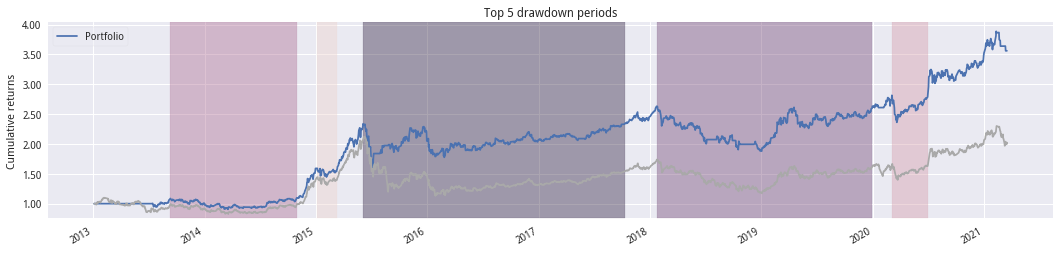

In [213]:
show_worst_drawdown_periods(algorithm_ret.dropna())
fig,ax = plt.subplots(figsize=(18,4))
plot_drawdown_periods(algorithm_ret.dropna(),5,ax)
ax.plot(benchmark['close'] / benchmark['close'][0],color='darkgray')

In [217]:
trade_info.show_all()

## 构思四:

思路来源[基于相对强弱下单向波动差值应用](https://www.joinquant.com/view/community/detail/ddf35e24e9dbad456d3e6beaf0841262)

In [221]:
# 信号获取
top_factor_val = factor_df[rank_df=='G5'].mean(axis=1)
bottom_factor_val = factor_df[rank_df=='G1'].mean(axis=1)

# 时间设置
startDt = top_factor_val.index.min().strftime('%Y-%m-%d')
endDt = top_factor_val.index.max().strftime('%Y-%m-%d')

# 基准
benchmark = get_price('000300.XSHG',startDt,endDt,fields='close',panel=False)

In [307]:
benchmark_ret = benchmark['close'].pct_change()

# 与上行收益相关的信号 矢量化处理 不用在这一步纠结未来函数的委托
tmp_signal = np.where(benchmark_ret > 0,1,0) * top_factor_val

N = 120 # 窗口为N
top_signal = tmp_signal.rolling(N).std()

基本上在信号处于下降趋势时指数上涨,信号上升时指数下跌,是一个负相关。不过阴影部分貌似信号失效了。

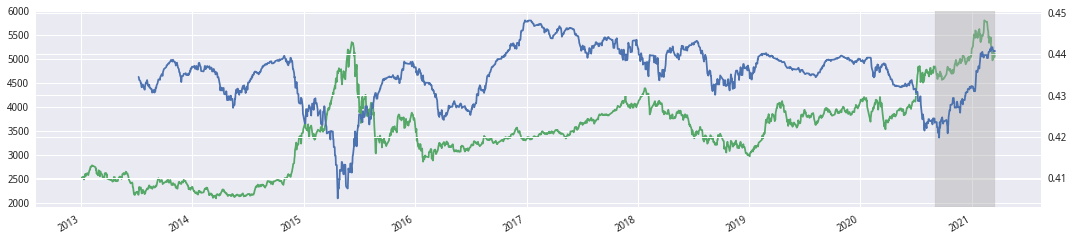

In [313]:
# 画图
top_signal.plot(secondary_y=True,figsize=(18,4))
benchmark['close'].plot()
plt.axvspan(xmin='2020-09-01',xmax=endDt,color='darkgray',alpha=0.4)

信号与未来的收益相关性情况

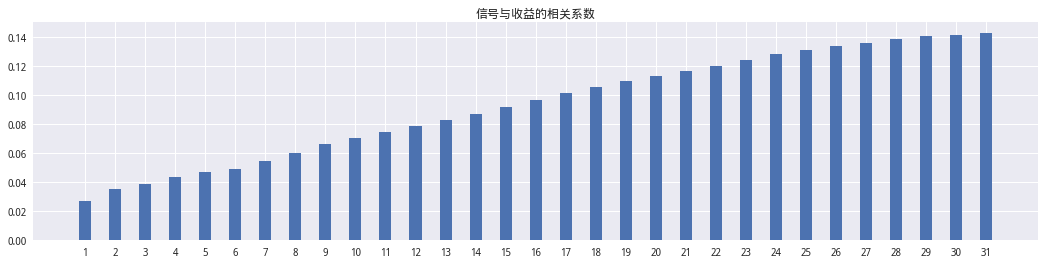

In [303]:
show_corrocef(benchmark['close'],top_signal,'信号与收益的相关系数')

**回测**

信号15日斜率向下持有(即小于0),向上时平仓

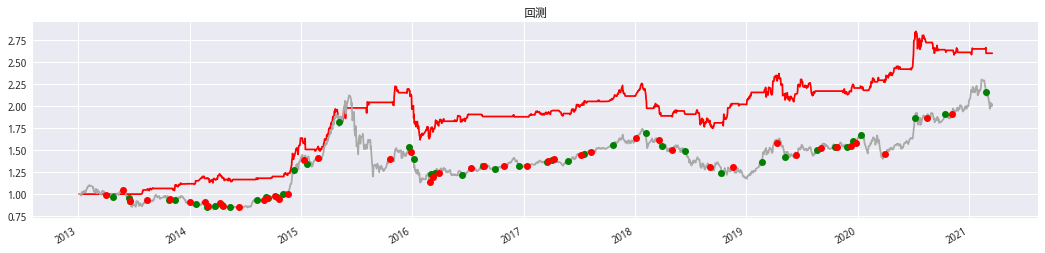

In [317]:
pos = (talib.LINEARREG_SLOPE(top_signal,15) < 0) * 1
next_ret = benchmark_ret.shift(-1)

algorithm_ret = pos * next_ret

trade_info = tradeAnalyze(flag,next_ret) # 初始化交易信息

(1 + ep.cum_returns(algorithm_ret)).plot(figsize=(18,4),title='回测',label='净值',color='r')
(benchmark['close'] / benchmark['close'][0]).plot(label='HS300',color='darkgray')
plot_trade_pos(trade_info,benchmark['close'] / benchmark['close'][0])
